In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from jcopml.plot import plot_missing_value
from jcopml.pipeline import cat_pipe,num_pipe


import os
import pickle

In [3]:
df=pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


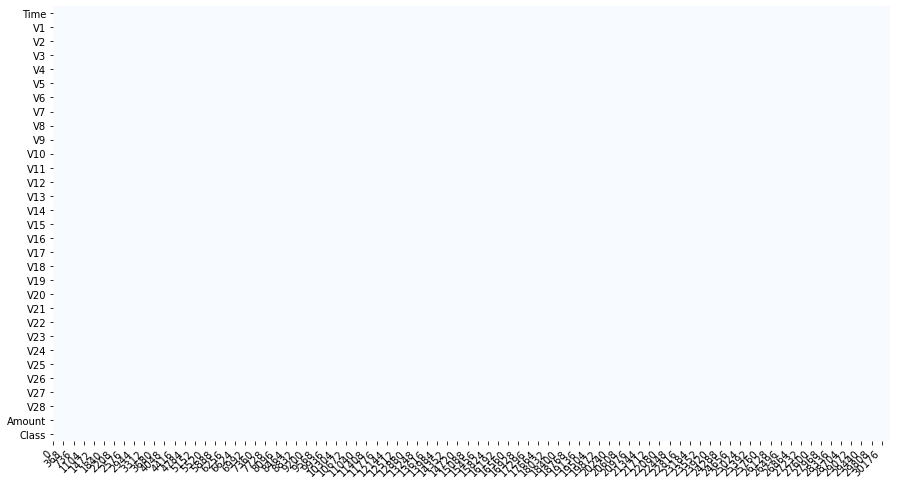

In [4]:
plot_missing_value(df)

In [5]:
X=df.drop(columns="Class")
y=df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [10]:
preprocessor=ColumnTransformer([
    ("numeric",num_pipe(scaling="standard"),X_train.columns)
])
pipeline=Pipeline([
    ("prep",preprocessor),
    ("algo",SVC(max_iter=500))
])

model=GridSearchCV(pipeline,gsp.svm_params,cv=3,n_jobs=-1,verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_,model.score(X_test,y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.999385069487148 0.9986471528717256 0.9996720773897361


### patut curiga kalau model nya nyaris sempurna tanpa adanya improvement.
*

### hal yang harus dicurigai
* data leakage
* data unbalance (pada kolom target terdapat perbedaan data yang cukup jauh,misal nya yang data 1 ada 12000 data, dan data 0 ada 1000 data)
* atau memang problem nya sesuatu yang sederhana

In [12]:
df.Class.value_counts()

0    30000
1      492
Name: Class, dtype: int64

kalau imbalance dataset jangan gunakan scoring yang akurasi, tapi gunakan f1 score, cara pakai nya "scoring=f1"
* f1 score adalah scoring yang telah mempertimbangkan data yang unbalance

In [13]:
preprocessor=ColumnTransformer([
    ("numeric",num_pipe(scaling="standard"),X_train.columns)
])
pipeline=Pipeline([
    ("prep",preprocessor),
    ("algo",SVC(max_iter=500))
])

model=GridSearchCV(pipeline,gsp.svm_params,cv=3,scoring='f1',n_jobs=-1,verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_,model.score(X_test,y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 1000.0, 'algo__gamma': 0.001}
0.980595084087969 0.9574909514939499 0.9896907216494846


untuk memastikan bahwa model nya sudah tidak unbalence adalah dengan plot menggunakan confussin matrix, konsep nya adalah ploting data sebenarnya dibandingkan data prediction dari model yang kita buat

In [14]:
from jcopml.plot import plot_confusion_matrix

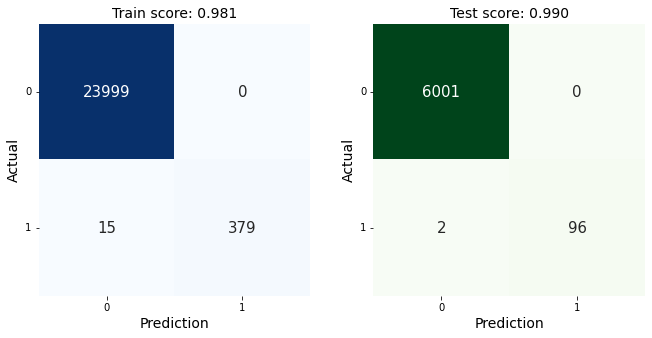

In [15]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

# feature engineering untuk data yang unbalance
### gunakan class weight
* konsep nya dengan membobotkan agar mechine learning lebih fokus belajar ke data yang mana bobot nya lebih besar (contoh pada data 0 dibobotkan 0.5 dan pada data 1 dibobotkan 0.95, jadi ML akan lebih fokus belajar ke data 1. dan ini bisa jugadi tuning

In [ ]:
[
    {0:0.05, 1:0.95},
    {0:0.1, 1:0.9},
    {0:0.25, 1:0.75}
]

In [16]:
gsp.svm_params

{'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [18]:
preprocessor=ColumnTransformer([
    ("numeric",num_pipe(scaling="standard"),X_train.columns)
])
pipeline=Pipeline([
    ("prep",preprocessor),
    ("algo",SVC(max_iter=500))
])

parameter = {
    
    'algo__gamma': np.logspace(-3,3,7),
    'algo__C': np.logspace(-3,3,7),
    'algo__class_weight':[
            {0:0.05, 1:0.95},
            {0:0.1, 1:0.9},
            {0:0.25, 1:0.75}]
    
}

model=GridSearchCV(pipeline,param_grid=parameter,cv=3,scoring='f1',n_jobs=-1,verbose=1)
model.fit(X_train,y_train)

print(model.best_params_)
print(model.score(X_train,y_train), model.best_score_,model.score(X_test,y_test))

Fitting 3 folds for each of 147 candidates, totalling 441 fits


C:\Users\Rahmat\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'algo__C': 100.0, 'algo__class_weight': {0: 0.1, 1: 0.9}, 'algo__gamma': 0.01}
0.9923857868020305 0.9606700001671838 0.9748743718592964


atau bisa juga gunakan list comprehansion agar mempersingkat code pada tuning class weight

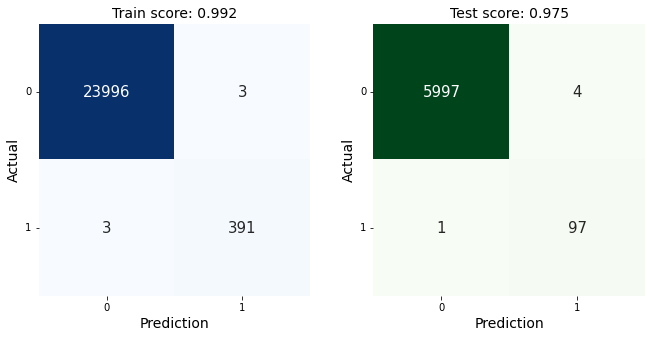

In [19]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [17]:
[{0: x, 1:1-x} for x in [0.05,0.1,0.25]]

[{0: 0.05, 1: 0.95}, {0: 0.1, 1: 0.9}, {0: 0.25, 1: 0.75}]